In [225]:
import os
import sys
sys.path.append("../analysis/physiology/")
import tpc

import xarray as xr

import gcsfs
GCP_PROJECT_ID = '170771369993'
OISST_GCP = 'oisst/oisst.zarr'

import numpy as np

import pandas as pd

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy.feature as cf

import seaborn as sns

# Validate Single Isolate (#`240`: NEPacific) Across Multiple Years 

This notebook is a continuation from a previous ([`whole_year_nepac_sentinel3.ipynb`](whole_year_nepac_sentinel3.ipynb), where Sentinel 3 data was acquired and processed.).

Here we take the derived Chl-$\alpha$ data and compare to isolate performance. 

## Data

In [9]:
plankton = pd.read_csv("../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/traits_derived_2016_01_29.csv", engine='python')

plankton = plankton[
    (plankton.habitat == 'marine') & 
    (plankton.curvequal == 'good')
]
chosen_isolate = plankton[plankton['isolate.code'] == 240]

**Load Performance + OISST**

In [10]:
isolate_performance_perf = xr.open_zarr(
    "../data/isolate_mhw_performance.zarr/isolate_mhw_performance.zarr/"
)

In [11]:
fs = gcsfs.GCSFileSystem(project=GCP_PROJECT_ID, token="../gc-pangeo.json")
oisst = xr.open_zarr(fs.get_mapper(OISST_GCP))
oisst = oisst.assign_coords(lon=(((oisst.lon + 180) % 360) - 180)).sortby('lon')

**Load Chl-$\alpha$ Data**

In [12]:
chl_df = pd.read_csv(
    "sentinel3-20160425-20190503.csv", 
).sort_values('date').dropna()
chl_df.date = pd.to_datetime(chl_df.date)


**Select MHW data**

In [14]:
mhw_performance = isolate_performance_perf.sel(
    isolate=chosen_isolate['isolate.code'].values, 
    time=slice(chl_df.date.min(), chl_df.date.max())
)

## Begin Plots

In [15]:
def lowess_smooth(data):
    from statsmodels.nonparametric.smoothers_lowess import lowess
    
    endog = data.values
    exog = data.index.values
    
    smooth = lowess(endog, exog)
    index, xformed = np.transpose(smooth)

    return pd.Series(xformed, index=pd.to_datetime(index)) 

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


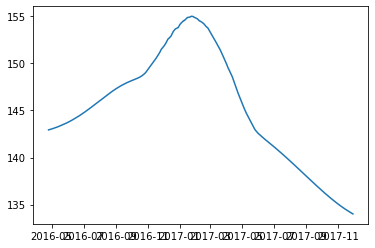

In [16]:
plt.plot(lowess_smooth(chl_df.set_index('date').chl_oc4me))

In [17]:
def add_mhw_bands(performance, oisst, ax):
    mhw_bands = performance.where(performance.mhw > 0, drop=True)
    mhw_band_starts = oisst.time.values[np.unique(mhw_bands.index_start).astype('int')]
    mhw_band_ends = oisst.time.values[np.unique(mhw_bands.index_end).astype('int')]
    [ax.axvspan(start, end, color='grey', alpha=0.2, zorder=-1) for start, end in zip(mhw_band_starts, mhw_band_ends)]

In [18]:
chl_rolling = chl_df.drop_duplicates('date').set_index('date').resample("1D").ffill().rolling(window=30, min_periods=1).mean().reset_index()

In [19]:
scale = tpc.physiological_scaler(chosen_isolate)


../analysis/physiology/tpc.py:12: FutureWarning: `item` has been deprecated and will be removed in a future version
  max_performance = physio_data['mu.g.opt.val.list'].item() # max growth rate


In [27]:
selected_sst = oisst.sel(
    lat = chosen_isolate['isolation.latitude'],
    lon = chosen_isolate['isolation.longitude'],
    time = mhw_performance.time,     
    method='nearest'
)

In [28]:

def validate_threepanel(date_range, fig, gs):
    
    gs = gs.subgridspec(3, 1)
    sst_ax = fig.add_subplot(gs[0])
    if date_range is not None:
        year = pd.to_datetime(date_range[0]).year
    else: 
        year = "All"
        


    selected_sst.sst.plot(ax=sst_ax, color='black', label='SST')
    mhw_performance.clim_seas.plot(ax=sst_ax, color='blue', label='Clim.')
    mhw_performance.clim_thresh.plot(ax=sst_ax, color='green', label='Thresh.')
    sst_ax.set_ylabel("SST [deg C]")
    sst_ax.set_title("")
    sst_ax.set_xlabel("")
    sst_ax.set_title(f"{year}", loc='center')
    sst_ax.annotate("MHW", (0.03, 0.95), xycoords='axes fraction', ha='left', va='top',
                bbox=dict(facecolor='w', edgecolor='k'), color='k')
    
    # sst_ax.set_xlim(['20160101', '20170101'])

    warm_mask = (mhw_performance.mhw > 0).values.ravel()

    sst_ax.fill_between(
        x =mhw_performance.time.values, 
        y1= mhw_performance.clim_thresh.values.ravel(), 
        y2=selected_sst.sst.values.ravel(),
        where=warm_mask, 
        color='red'
    )
    add_mhw_bands(mhw_performance, oisst, ax=sst_ax)


    sst_ax.legend(loc='lower center', ncol=3)


    performance_ax = fig.add_subplot(gs[1], sharex=sst_ax)
    performance_diff = scale(mhw_performance.performance - mhw_performance.performance_clim)

    # _p0 = perf_diff.plot(label='Performance DIff.', ax=perf_ax)
    performance_ax.set_ylim([-0.5, 0.5])

    positive_diff = (performance_diff > 0).values.ravel()
    negative_diff = (performance_diff < 0).values.ravel()

    add_mhw_bands(mhw_performance, oisst, ax=performance_ax)

    performance_ax.fill_between(
        performance_diff.time.values.ravel(), 
        0, 
        performance_diff.values.ravel(),
        where = positive_diff,
        color='xkcd:kelly green', 
        label='Better Perf.'
    )
    /
    performance_ax.fill_between(
        performance_diff.time.values.ravel(), 
        0, 
        performance_diff.values.ravel(),
        where = negative_diff,
        color='xkcd:brick red',
        label="Worse Perf."
    )

    performance_ax.legend(loc='lower center', ncol=3)
    performance_ax.axhline(0.0, alpha=1, linestyle='--', color='red')
#     performance_ax.set_title("B) Isolate Performance Difference", loc='left')
    performance_ax.set_ylabel("Scaled Performance Diff.")
    performance_ax.annotate("Isolate Performance", (0.03, 0.95), xycoords='axes fraction', ha='left', va='top',
                bbox=dict(facecolor='w', edgecolor='k'), color='k')


    chl_ax = fig.add_subplot(gs[2])
    # _p0 = mhw_performance.performance.plot(label='Isolate Performance', ax=chl_ax)

    # chl_ax.set_xlim(['20160101', '20170101'])
    _p1 = chl_ax.scatter(chl_df.date, chl_df.chl_oc4me, color='none', alpha=0.4, edgecolor='red', zorder=-1,  label=r'Sentinel-3 Chl-$\alpha$ Observation')

    chl_ax.set_ylabel(r"mg (chl-a) m$^{-3}$")
    # _p2 = chl_twinax.plot(
    #     lowess_smooth(chl_df.dropna(subset=['chl']).set_index('date').chl),
    #     linewidth=2, color='red', linestyle='--',
    #     label=r'Sentinel-3 Chl-$\alpha$ LOWESS'
    # )


    _p2 = chl_ax.plot(
        chl_rolling.date, chl_rolling.chl_oc4me,
        linewidth=1.1, color='red', linestyle='--',
        label=r'Sentinel-3 Chl-$\alpha$ 30-Day Mean'
    )

    add_mhw_bands(mhw_performance, oisst, ax=chl_ax)


    for label in chl_ax.get_xticklabels():
        label.set_ha("right")
        label.set_rotation(30)

    # lines, labels = chl_ax.get_legend_handles_labels()
    # lines2, labels2 = chl_twinax.get_legend_handles_labels()
    # chl_twinax.legend(lines + lines2, labels + labels2, loc='center right', fancybox=True, bbox_to_anchor=(1.75, 0.5))

    chl_ax.legend(fancybox=True, loc='lower center')#bbox_to_anchor=(1.75, 0.5), loc='center right')
    chl_ax.set_title("")
#     chl_ax.set_title("C) Sentinel 3 Validation", loc='left')
    chl_ax.annotate("Sentinel 3 Chlorophyll", (0.03, 0.95), xycoords='axes fraction', ha='left', va='top',
            bbox=dict(facecolor='w', edgecolor='k'), color='k')

    if date_range is not None:
        sst_ax.set_xlim(date_range)
        performance_ax.set_xlim(date_range)
        chl_ax.set_xlim(date_range)
        
    sst_ax.set_xticklabels([])
    performance_ax.set_xticklabels([])

# plt.savefig("nepac_s3_years_combined.pdf", bbox_inches='tight')

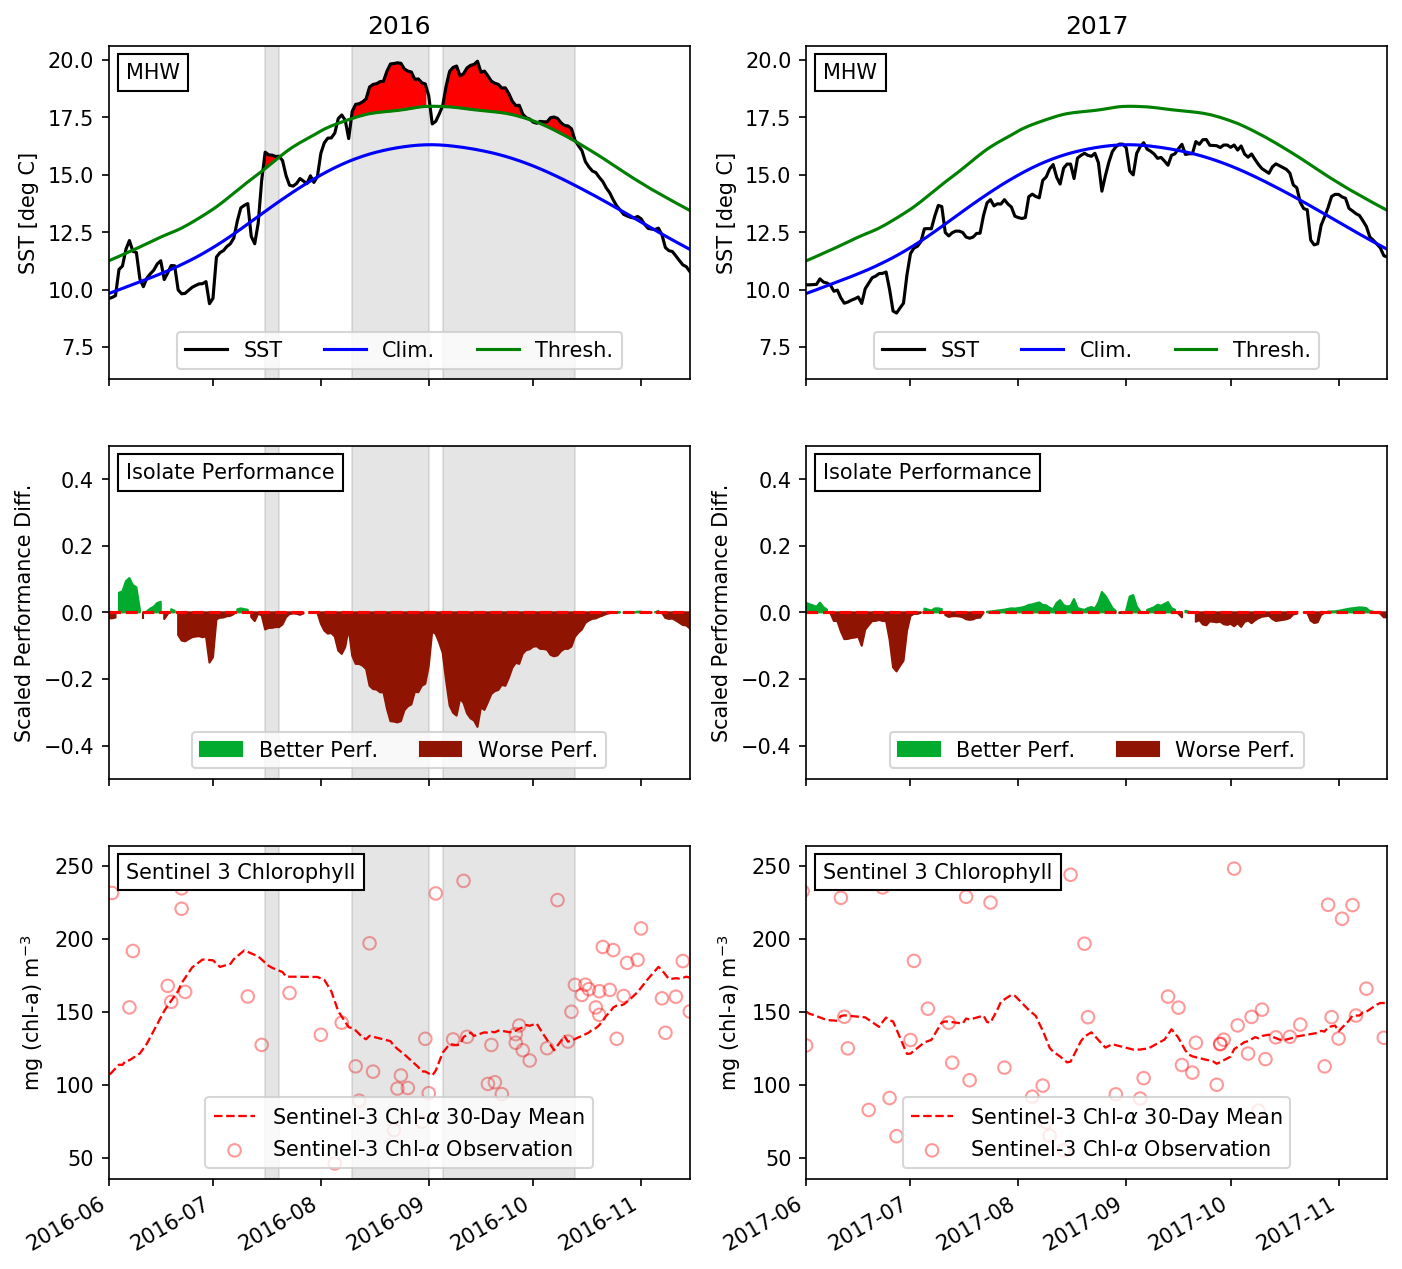

In [29]:
fig = plt.figure(figsize=(11, 10), dpi=150)

gs = fig.add_gridspec(1, 2)

validate_threepanel( ['20160601', '20161115'], fig, gs[0])
validate_threepanel(['20170601', '20171115'], fig, gs[1])
plt.savefig("nepac_s3_year_comparision.pdf", bbox_inches='tight')

## Comparison of means / distributions?

In [258]:
warm_mask = (mhw_performance.mhw > 0).values.ravel()

In [260]:
mhw_times = mhw_performance.time[warm_mask]

In [265]:
mhw_days_chl = chl_df[chl_df.date.isin(mhw_times.values)]

In [270]:
oneyear = np.timedelta64(365, "D")

In [273]:
oneyearlater_times = (mhw_times + oneyear)

In [276]:
nonmhw_seasonal_chl = chl_df[chl_df.date.isin(oneyearlater_times.values)]

In [289]:
nonmhw_seasonal_oc4me = pd.DataFrame(nonmhw_seasonal_chl.chl_oc4me).assign(type='nonmhw')
mhw_oc4me = pd.DataFrame(mhw_days_chl.chl_oc4me).assign(type='mhw')

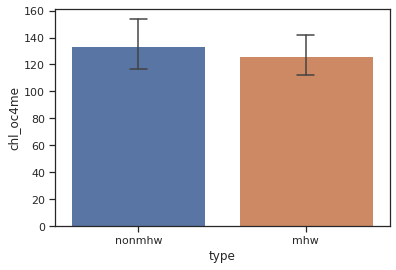

In [299]:
sns.barplot(y='chl_oc4me', x='type', data=pd.concat([nonmhw_seasonal_oc4me, mhw_oc4me]), errwidth=1.5, capsize=0.1)

What about if we create a scatterplot with Chlorophyll on the X axis and Performance Difference on the Y?

In [84]:
offsettimes = [d+10 for d in chl_df.date.values if d + np.timedelta64(10, "D") in mhw_performance.time.values]

In [77]:
chl_df.date

0     2016-04-25
1     2016-04-26
10    2016-05-02
16    2016-05-06
17    2016-05-07
         ...    
829   2017-11-20
830   2017-11-21
835   2017-11-24
837   2017-11-25
843   2017-11-29
Name: date, Length: 205, dtype: datetime64[ns]

In [274]:
CHL_LAG_DAYS = -1

chl_performance = isolate_performance_perf.sel(
    isolate=chosen_isolate['isolate.code'].values, 
    time = chl_df.date.values + np.timedelta64(CHL_LAG_DAYS, 'D')
)

chl_perfdiff = scale(chl_performance.performance - chl_performance.performance_clim)

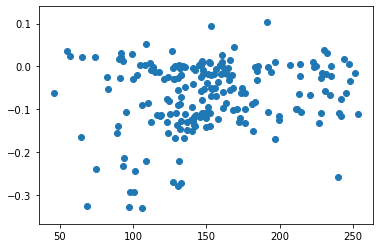

In [275]:
plt.scatter(
    x = chl_df.chl_oc4me,
    y = chl_perfdiff.values
)


In [276]:
combined = pd.DataFrame({
    'chl' : chl_df.chl_oc4me,
    'perfdiff': chl_perfdiff.values.ravel()
})

In [277]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std


In [278]:
mhw_color = 'xkcd:light red'
nonmhw_color = 'xkcd:ocean blue'

mhw_days = mhw_performance.where(mhw_performance.mhw > 0, drop=True).time.values
colors = [
    mhw_color if d in mhw_days else nonmhw_color for d in chl_df.date.values
]

In [281]:
chosen_isolate.group

169    diatoms
Name: group, dtype: object

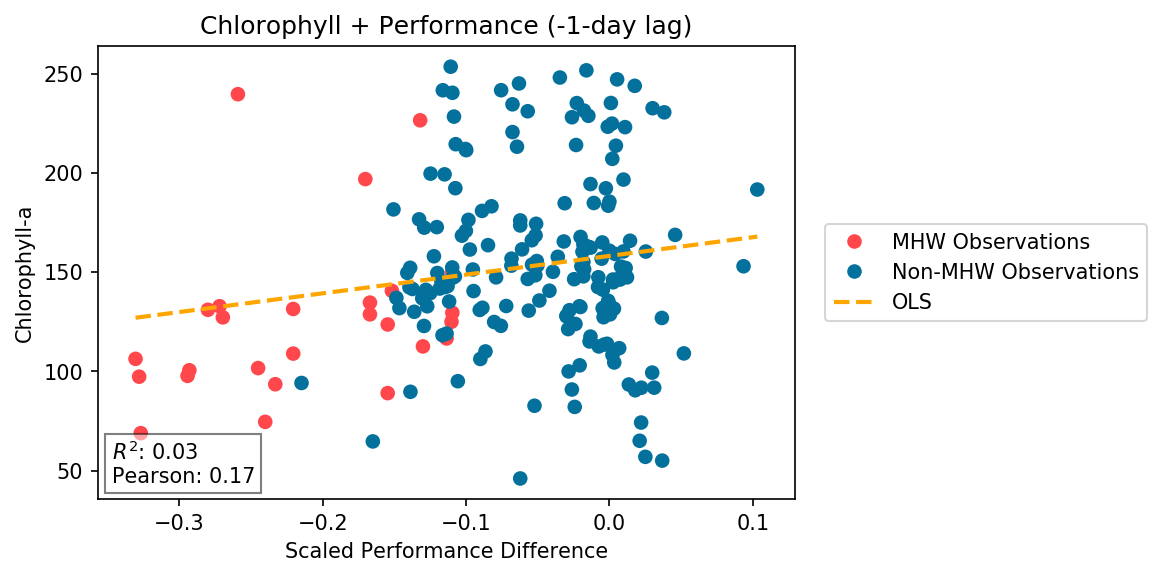

In [285]:


chl_m = smf.ols(formula = "chl ~ perfdiff", data=combined).fit()

prstd, iv_l, iv_u = wls_prediction_std(chl_m)

fig, ax = plt.subplots(dpi=150)

ax.scatter(x=combined.perfdiff.values, y=combined.chl.values, c=colors)
ax.plot(
    combined.perfdiff.sort_values(), 
    chl_m.fittedvalues[combined.perfdiff.sort_values().index],
    linestyle='--',
    linewidth=2,
    linecolor='orange'
)
# ax.plot(combined.perfdiff, iv_u, 'r--')
# ax.plot(combined.perfdiff, iv_l, 'r--')

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=1, alpha=0.5)

a = ax.annotate(
    f"$R^2$: {chl_m.rsquared:.2f}\nPearson: {combined.corr().chl.perfdiff:.2f}", 
    (0.02, .13), 
    horizontalalignment='left', 
    verticalalignment='top', 
    xycoords='axes fraction',
    
    bbox=bbox_props
)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='MHW Observations',
                          markerfacecolor=mhw_color, markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Non-MHW Observations',
                          markerfacecolor=nonmhw_color, markersize=8),
    Line2D([0], [0], linestyle='--', color='orange', label='OLS', linewidth=2)
                  ]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.52, 0.5), loc='center right')
plt.xlabel("Scaled Performance Difference")
plt.ylabel("Chlorophyll-a")
plt.title(f"Chlorophyll + Performance ({CHL_LAG_DAYS}-day lag)")
plt.savefig(f"chl_perf_{CHL_LAG_DAYS}d_lag.png", dpi=150, bbox_inches='tight')

In [286]:
mhw_days = mhw_performance.where(mhw_performance.mhw > 0, drop=True).time.values
mhw_bool = [
    True if d in mhw_days else False for d in chl_df.date.values
]

In [296]:
chl_mhw = smf.ols(formula = "chl ~ perfdiff*mhw", data=combined).fit()
chl_mhw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    chl   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     4.130
Date:                Wed, 27 May 2020   Prob (F-statistic):            0.00721
Time:                        22:16:20   Log-Likelihood:                -1063.3
No. Observations:                 205   AIC:                             2135.
Df Residuals:                     201   BIC:                             2148.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      154.8191      4.221     36.678      0.000     146.496     163.142
perfdiff       -14.9565     57.952     -0.258      0.797    -129.228      99.315
mhw              7.9599     26.394      0.302      0.763     -44.084      60.004
perfdiff:mhw   187.8879    130.284      1.442      0.151     -69.011     444.787
==============================================================================
Omnibus:                        5.428   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.066   Jarque-Bera (JB):                5.238
Skew:                           0.389   Prob(JB):                       0.0729
Kurtosis:                       3.085   Cond. No.                         44.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [297]:
chl_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    chl   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     6.038
Date:                Wed, 27 May 2020   Prob (F-statistic):             0.0148
Time:                        22:18:38   Log-Likelihood:                -1066.4
No. Observations:                 205   AIC:                             2137.
Df Residuals:                     203   BIC:                             2143.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    158.1232      4.015     39.380      0.000     150.206     166.040
perfdiff      94.2668     38.362      2.457      0.015      18.628     169.906
==============================================================================
Omnibus:                        3.927   Durbin-Watson:                   1.686
Prob(Omnibus):                  0.140   Jarque-Bera (JB):                3.845
Skew:                           0.335   Prob(JB):                        0.146
Kurtosis:                       2.968   Cond. No.                         12.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [293]:
combined = combined.assign(mhw=np.array(mhw_bool).astype('int'))

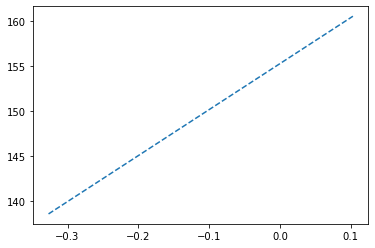

In [270]:
plt.plot(
    combined.perfdiff.sort_values(), 
    chl_m.fittedvalues[combined.perfdiff.sort_values().index],
    linestyle='--'
)

Int64Index([167, 199, 192, 206, 166, 204, 173, 178, 176, 161,
            ...
            570, 563,  16, 681,  17, 698, 712,  50, 697,  53],
           dtype='int64', length=205)

In [165]:
from sklearn import metrics

In [ ]:
metrics.pear

In [122]:
chl_m.conf_int(alpha=0.05, cols=None)

,0,1
Intercept,149.572947,165.559840
perfdiff,8.758827,161.231189


In [109]:
np.linspace(-0.3, 0.1)

array([-0.3       , -0.29183673, -0.28367347, -0.2755102 , -0.26734694,
       -0.25918367, -0.25102041, -0.24285714, -0.23469388, -0.22653061,
       -0.21836735, -0.21020408, -0.20204082, -0.19387755, -0.18571429,
       -0.17755102, -0.16938776, -0.16122449, -0.15306122, -0.14489796,
       -0.13673469, -0.12857143, -0.12040816, -0.1122449 , -0.10408163,
       -0.09591837, -0.0877551 , -0.07959184, -0.07142857, -0.06326531,
       -0.05510204, -0.04693878, -0.03877551, -0.03061224, -0.02244898,
       -0.01428571, -0.00612245,  0.00204082,  0.01020408,  0.01836735,
        0.02653061,  0.03469388,  0.04285714,  0.05102041,  0.05918367,
        0.06734694,  0.0755102 ,  0.08367347,  0.09183673,  0.1       ])

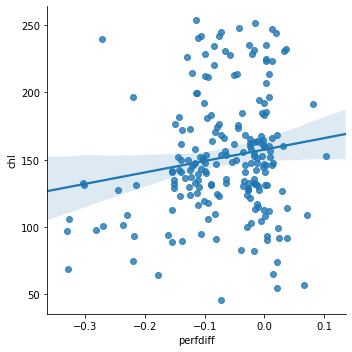

In [99]:
sns.lmplot(
    y='chl',
    x = 'perfdiff',
    data = combined
)


In [91]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [95]:
for lag in range(-10, 20):
    chl_performance = isolate_performance_perf.sel(
    isolate=chosen_isolate['isolate.code'].values, 
    time = chl_df.date.values + np.timedelta64(lag, 'D')
    )

    chl_perfdiff = scale(chl_performance.performance - chl_performance.performance_clim)
    combined = pd.DataFrame({
        'chl' : chl_df.chl_oc4me,
        'perfdiff': chl_perfdiff.values.ravel()
    })
    chl_m = smf.ols(formula = "chl ~ perfdiff", data=combined)
    r = chl_m.fit()
    print(lag, r.rsquared)

-10 0.00260626986938417
-9 0.005414920982719562
-8 0.0057492248175131655
-7 0.007876416534013164
-6 0.011894096344017724
-5 0.008278132018017192
-4 0.008819864154921642
-3 0.009719230237136167
-2 0.022500274663030062
-1 0.028886011821573465
0 0.023250992361440015
1 0.02220359482911094
2 0.01080945936409361
3 0.004700111684635688
4 0.002730202939168702
5 0.008461634997381062
6 0.008154826799447346
7 0.011515655053418228
8 0.00769221383139318
9 0.006853385558097114
10 0.010776669834525188
11 0.007196470343253658
12 0.004906935280902025
13 0.008268402201050074
14 0.014036710154601395
15 0.013191567154334782
16 0.020136638790625105
17 0.024500501668955454
18 0.024858159247363565
19 0.01965776515038553


In [284]:
chosen_isolate.iloc[0]

isolate.code                                             240
source                                     Northeast Pacific
isolation.latitude                                        45
isolation.longitude                                     -145
habitat                                               marine
name                                 Pseudo-nitzschia granii
speciesname                          Pseudo-nitzschia granii
former.name.1                                            NaN
former.name.2                                            NaN
strain                                                   NaN
clone                                                    NaN
species                                               granii
genus                                       Pseudo-nitzschia
family                                        Bacillariaceae
order                                          Bacillariales
class                                      Bacillariophyceae
phylum                  